# Setup

In [1]:
import plotly.io as pio
try:
    import google.colab
    print("Running as a Colab notebook")
    pio.renderers.default = "colab"
    %pip install transformer-lens fancy-einsum
    %pip install -U kaleido # kaleido only works if you restart the runtime. Required to write figures to disk (final cell)
except:
    print("Running as a Jupyter notebook")
    pio.renderers.default = "vscode"
    from IPython import get_ipython
    ipython = get_ipython()

Running as a Jupyter notebook


In [2]:
import torch
from fancy_einsum import einsum
from transformer_lens import HookedTransformer, HookedTransformerConfig, utils, ActivationCache
from torchtyping import TensorType as TT
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import einops
from typing import List, Union, Optional
from functools import partial
import pandas as pd
from pathlib import Path
import urllib.request
from bs4 import BeautifulSoup
from tqdm import tqdm
from datasets import load_dataset
import os
import json

os.environ["TOKENIZERS_PARALLELISM"] = "false" # https://stackoverflow.com/q/62691279
torch.set_grad_enabled(False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [3]:
!pip install circuitsvis
import circuitsvis as cv


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [4]:
pio.renderers.default='vscode'

def imshow(tensor, renderer=None, **kwargs):
    px.imshow(utils.to_numpy(tensor), color_continuous_midpoint=0.0, color_continuous_scale="RdBu", **kwargs).show(renderer)

def line(tensor, renderer=None, **kwargs):
    px.line(y=utils.to_numpy(tensor), **kwargs).show(renderer)

def scatter(x, y, xaxis="", yaxis="", caxis="", renderer=None, **kwargs):
    x = utils.to_numpy(x)
    y = utils.to_numpy(y)
    px.scatter(y=y, x=x, labels={"x":xaxis, "y":yaxis, "color":caxis}, **kwargs).show(renderer)

In [5]:
model = HookedTransformer.from_pretrained(
    "gpt2-large",
    center_unembed=True,
    center_writing_weights=True,
    fold_ln=True,
    refactor_factored_attn_matrices=True,
    device=device,
)

Using pad_token, but it is not set yet.


Loaded pretrained model gpt2-large into HookedTransformer


## Generate Prompts For GPT-4 Example Generation

In [23]:
EXPLANATION_JSON_FILE_PATH = "data/head_explanation_1_nh_to_exp.json"

# Load results
with open(EXPLANATION_JSON_FILE_PATH) as f:
    nh_to_exp_str_key = json.load(f)

# The key of the response dict is a string '((a, b), c)' where a, b, c are integers. COnvert to tuple of (a, b, c).
nh_to_exp = {tuple(int(value.strip()) for value in k.strip('()').split(',')):v for k,v in nh_to_exp_str_key.items()}

# Load neuron word (inside neuron_finder_results)
with open("data/neuron_finder_results.json", "r") as f:
    neuron_finder_results = json.load(f)

neuron_to_token = {}

for layer in neuron_finder_results.keys():
    for neuron_ind in neuron_finder_results[layer].keys():
        neuron_to_token[(int(layer), int(neuron_ind))] = neuron_finder_results[layer][neuron_ind][0]

# We have nh_to_exp, which is a dict of the form (layer, neuron, head) -> explanation string
# and neuron_to_token, which is a dict of the form (layer, neuron) -> token

In [9]:
nh_to_exp[(31, 988, 558)]

'contains a phrase where a specific term, concept, or mechanism is introduced and then immediately defined or referred to using the term "called." In other words, the attention head is activated when there is a direct association between a previously mentioned item and the term "called." \n\nIn the inactive examples, the term "called" is often preceded by an additional descriptor (e.g., "also called" or "sometimes called"), or the association between the preceding concept and the term "called" is not as direct or immediate. This difference in structure or phrasing may be the reason why the attention head remains inactive in these cases.'

In [10]:
import activating_dataset, prompt_generators
from importlib import reload
reload(activating_dataset)
reload(prompt_generators)
# Load Dataset
from activating_dataset import ActivatingDataset
from prompt_generators import GenerationPrompt

all_neuron_heads = list(nh_to_exp.keys())

eg_generation_prompts = {}

for neuron_head in all_neuron_heads:
    explanation_str = nh_to_exp[neuron_head].replace("\n", "")
    token = neuron_to_token[(neuron_head[0], neuron_head[1])]
    prompt_gen = GenerationPrompt(explanation_str, token)
    gpt_4_prompt = prompt_gen.get_prompt(num_examples=10, generate_negative=True)
    eg_generation_prompts[neuron_head] = gpt_4_prompt

In [12]:
print(eg_generation_prompts[(31, 3621, 468)])

We are studying attention heads in a transformer architecture neural network. Each attention head looks for some particular thing in a short document.
The attention head being studied helps to predict that the next token is " only", but it is only active in some documents and not others.
Explanation: """
In particular, this attention head is active when the document contains a statement or fact that is limited or restricted by the term "only". In the active examples, the attention head is highlighting a specific context or scenario where something is exclusive or unique. For example, "Excersire can only work if you are following a proper diet" implies that exercise alone is not enough.In the inactive examples, the term "only" is often used to emphasize the sole purpose or aspect of something rather than indicating exclusivity or a limitation in a broader context. For example, "for one reason and one reason only" uses "only" to stress that there is just one reason, but it doesn't indica

## Run GPT-4 to generate examples

In [14]:
import json
import os
filename = "data/eg_generation_1.jsonl"

if os.path.isfile(filename):
    raise Exception("File already exists!")

jobs = [
            {"model":"gpt-4",
            "messages":[{"role": "user", "content": gpt_4_prompt}],
            "max_tokens":800, 
        } for gpt_4_prompt in eg_generation_prompts.values()]

with open(filename, "w") as f:
    for job in jobs:
        json_string = json.dumps(job)
        f.write(json_string + "\n")

In [ ]:
import time
now = int(time.time())
print(now)

#########################################################################################
# WHEN YOU UPDATE THE CELL, REMEMBER TO UPDATE THE JSONL FILE NAME IF YOU'VE CHANGED IT #
#########################################################################################
current_time = 1686792857

if current_time + 20 < now: # Sanity check to make sure you don't spam this cell
    raise Exception("Update the current_time variable to be able to run this cell! Copy and paste the number above.")
else:
    print("all gucci")
    !python3 api_request_parallel_processor.py --requests_filepath data/eg_generation_1.jsonl --request_url https://api.openai.com/v1/chat/completions --max_requests_per_minute 100 --max_tokens_per_minute 20000
    # ^ This is very scary because the stdout looks like it sends repeated requests for the same thing so just run it in terminal


## Create Prompts For Iteration

In [29]:
# import reload from wherever
from importlib import reload
import prompt_generators
reload(prompt_generators)
from prompt_generators import IterationPromptGen
from neuron_functions import get_head_attribution

In [17]:
with open("data/eg_generation_1_nh_to_exp.json") as f:
    generated_examples_str_key = json.load(f)
    generated_examples = {tuple(int(value.strip()) for value in k.strip('()').split(',')): v for k, v in generated_examples_str_key.items()}

In [32]:
check_if_responses_can_be_processed = False # Do this first
iteration_prompts = {}
iteration_prompts_ref = {}

for i, (neuron_head, generated_example) in tqdm(enumerate(generated_examples.items())):
    neuron, head_no = (neuron_head[0], neuron_head[1]), neuron_head[2]
    relevant_token = neuron_to_token[neuron]

    capitalised_token = relevant_token[0] + relevant_token[1].capitalize() + relevant_token[2:] # we can do this because by definition we got " word" tokens
    
    if 'is_inactive' in generated_example:
        generated_example = generated_example.replace('is_inactive', 'is inactive') # For some reason this was in one prompt

    # Extract the positive and negative examples. 
    def get_list_of_strings(string):
        return [s[3:] if s[1] == "." else s[4:] for s in string.split("\n") if s != ''] # Wonky but it works

    positive_examples = generated_example.split("Examples where the attention head is active:")[1].split("Examples where the attention head is inactive:")[0]
    negative_examples = generated_example.split("Examples where the attention head is inactive:")[1]
    positive_examples = get_list_of_strings(positive_examples)
    negative_examples = get_list_of_strings(negative_examples)

    # Cut off the examples at the last instance of <token>. They may happen more than once.
    positive_examples = [eg[:max(eg.rfind(relevant_token), eg.rfind(capitalised_token))] for eg in positive_examples]
    negative_examples = [eg[:max(eg.rfind(relevant_token), eg.rfind(capitalised_token))] for eg in negative_examples]

    if not check_if_responses_can_be_processed:
        # Load and Truncate Prompts (slightly cursed way of string -> token -> truncated tokens -> string)
        trunc_prompts = positive_examples + negative_examples
        # Run head attribution
        tokens = model.to_tokens(trunc_prompts, prepend_bos=True).to(device=device)
        original_logits, cache = model.run_with_cache(tokens, )

        # # Prepare prompts by heads
        head_attribution = get_head_attribution(model, cache, tokens, neuron)
        _, top_heads = torch.topk(head_attribution, k=3, dim=-1)
        top_heads_list = top_heads.tolist()

        top_heads_positive = top_heads_list[:len(positive_examples)]
        top_heads_negative = top_heads_list[len(positive_examples):]

        positive_examples_correct = []
        negative_examples_correct = []

        for i, example in enumerate(positive_examples):
            if head_no in top_heads_positive[i]:
                positive_examples_correct.append(example)
            else:
                negative_examples_correct.append(example)

        for i, example in enumerate(negative_examples):
            if head_no in top_heads_negative[i]:
                positive_examples_correct.append(example)
            else:
                negative_examples_correct.append(example)

        explanation_str = nh_to_exp[neuron_head].replace("\n", "")
        iter_gen = IterationPromptGen(positive_examples, negative_examples, positive_examples_correct, negative_examples_correct, relevant_token, explanation_str)
        iteration_prompt = iter_gen.get_prompt()

        iteration_prompts[neuron_head] = iteration_prompt
        iteration_prompts_ref[neuron_head] = [positive_examples, negative_examples, positive_examples_correct, negative_examples_correct]

0it [00:00, ?it/s]

Tried to stack head results when they weren't cached. Computing head results now


1it [00:04,  4.67s/it]

Tried to stack head results when they weren't cached. Computing head results now


2it [00:09,  4.66s/it]

Tried to stack head results when they weren't cached. Computing head results now


3it [00:14,  4.69s/it]

Tried to stack head results when they weren't cached. Computing head results now


4it [00:16,  3.92s/it]

Tried to stack head results when they weren't cached. Computing head results now


5it [00:20,  3.89s/it]

Tried to stack head results when they weren't cached. Computing head results now


6it [00:25,  4.11s/it]

Tried to stack head results when they weren't cached. Computing head results now


7it [00:30,  4.51s/it]

Tried to stack head results when they weren't cached. Computing head results now


8it [00:33,  4.14s/it]

Tried to stack head results when they weren't cached. Computing head results now


9it [00:35,  3.50s/it]

Tried to stack head results when they weren't cached. Computing head results now


10it [00:39,  3.66s/it]

Tried to stack head results when they weren't cached. Computing head results now


11it [00:43,  3.54s/it]

Tried to stack head results when they weren't cached. Computing head results now


12it [00:47,  3.83s/it]

Tried to stack head results when they weren't cached. Computing head results now


13it [00:53,  4.44s/it]

Tried to stack head results when they weren't cached. Computing head results now


14it [00:59,  5.02s/it]

Tried to stack head results when they weren't cached. Computing head results now


15it [01:03,  4.45s/it]

Tried to stack head results when they weren't cached. Computing head results now


16it [01:04,  3.61s/it]

Tried to stack head results when they weren't cached. Computing head results now


17it [01:06,  3.19s/it]

Tried to stack head results when they weren't cached. Computing head results now


18it [01:10,  3.37s/it]

Tried to stack head results when they weren't cached. Computing head results now


19it [01:15,  3.71s/it]

Tried to stack head results when they weren't cached. Computing head results now


20it [01:17,  3.34s/it]

Tried to stack head results when they weren't cached. Computing head results now


21it [01:19,  2.75s/it]

Tried to stack head results when they weren't cached. Computing head results now


22it [01:22,  3.00s/it]

Tried to stack head results when they weren't cached. Computing head results now


23it [01:27,  3.47s/it]

Tried to stack head results when they weren't cached. Computing head results now


24it [01:31,  3.75s/it]

Tried to stack head results when they weren't cached. Computing head results now


25it [01:34,  3.58s/it]

Tried to stack head results when they weren't cached. Computing head results now


26it [01:37,  3.17s/it]

Tried to stack head results when they weren't cached. Computing head results now


27it [01:42,  3.84s/it]

Tried to stack head results when they weren't cached. Computing head results now


28it [01:45,  3.72s/it]

Tried to stack head results when they weren't cached. Computing head results now


29it [01:47,  3.23s/it]

Tried to stack head results when they weren't cached. Computing head results now


30it [01:49,  2.80s/it]

Tried to stack head results when they weren't cached. Computing head results now


31it [01:54,  3.50s/it]

Tried to stack head results when they weren't cached. Computing head results now


32it [01:58,  3.40s/it]

Tried to stack head results when they weren't cached. Computing head results now


33it [01:59,  2.83s/it]

Tried to stack head results when they weren't cached. Computing head results now


34it [02:01,  2.51s/it]

Tried to stack head results when they weren't cached. Computing head results now


35it [02:02,  2.20s/it]

Tried to stack head results when they weren't cached. Computing head results now


36it [02:04,  1.99s/it]

Tried to stack head results when they weren't cached. Computing head results now


37it [02:08,  2.53s/it]

Tried to stack head results when they weren't cached. Computing head results now


38it [02:10,  2.61s/it]

Tried to stack head results when they weren't cached. Computing head results now


39it [02:15,  3.07s/it]

Tried to stack head results when they weren't cached. Computing head results now


40it [02:17,  2.90s/it]

Tried to stack head results when they weren't cached. Computing head results now


41it [02:18,  2.43s/it]

Tried to stack head results when they weren't cached. Computing head results now


42it [02:22,  2.81s/it]

Tried to stack head results when they weren't cached. Computing head results now


43it [02:28,  3.62s/it]

Tried to stack head results when they weren't cached. Computing head results now


44it [02:30,  3.36s/it]

Tried to stack head results when they weren't cached. Computing head results now


45it [02:32,  2.77s/it]

Tried to stack head results when they weren't cached. Computing head results now


46it [02:33,  2.44s/it]

Tried to stack head results when they weren't cached. Computing head results now


47it [02:35,  2.15s/it]

Tried to stack head results when they weren't cached. Computing head results now


48it [02:36,  1.90s/it]

Tried to stack head results when they weren't cached. Computing head results now


49it [02:38,  1.75s/it]

Tried to stack head results when they weren't cached. Computing head results now


50it [02:39,  1.69s/it]

Tried to stack head results when they weren't cached. Computing head results now


51it [02:40,  1.57s/it]

Tried to stack head results when they weren't cached. Computing head results now


52it [02:48,  3.28s/it]

Tried to stack head results when they weren't cached. Computing head results now


53it [02:59,  5.64s/it]

Tried to stack head results when they weren't cached. Computing head results now


54it [03:03,  5.11s/it]

Tried to stack head results when they weren't cached. Computing head results now


55it [03:04,  4.09s/it]

Tried to stack head results when they weren't cached. Computing head results now


56it [03:09,  4.19s/it]

Tried to stack head results when they weren't cached. Computing head results now


57it [03:12,  3.82s/it]

Tried to stack head results when they weren't cached. Computing head results now


58it [03:14,  3.36s/it]

Tried to stack head results when they weren't cached. Computing head results now


59it [03:19,  3.79s/it]

Tried to stack head results when they weren't cached. Computing head results now


60it [03:22,  3.49s/it]

Tried to stack head results when they weren't cached. Computing head results now


61it [03:23,  2.83s/it]

Tried to stack head results when they weren't cached. Computing head results now


62it [03:24,  2.31s/it]

Tried to stack head results when they weren't cached. Computing head results now


63it [03:26,  2.15s/it]

Tried to stack head results when they weren't cached. Computing head results now


64it [03:27,  1.95s/it]

Tried to stack head results when they weren't cached. Computing head results now


65it [03:29,  1.80s/it]

Tried to stack head results when they weren't cached. Computing head results now


66it [03:33,  2.59s/it]

Tried to stack head results when they weren't cached. Computing head results now


67it [03:36,  2.63s/it]

Tried to stack head results when they weren't cached. Computing head results now


68it [03:42,  3.53s/it]

Tried to stack head results when they weren't cached. Computing head results now


69it [03:44,  3.34s/it]

Tried to stack head results when they weren't cached. Computing head results now


70it [03:47,  2.99s/it]

Tried to stack head results when they weren't cached. Computing head results now


71it [03:51,  3.48s/it]

Tried to stack head results when they weren't cached. Computing head results now


72it [03:54,  3.22s/it]

Tried to stack head results when they weren't cached. Computing head results now


73it [03:56,  2.91s/it]

Tried to stack head results when they weren't cached. Computing head results now


74it [03:58,  2.55s/it]

Tried to stack head results when they weren't cached. Computing head results now


75it [03:59,  2.15s/it]

Tried to stack head results when they weren't cached. Computing head results now


76it [04:02,  2.50s/it]

Tried to stack head results when they weren't cached. Computing head results now


77it [04:07,  3.04s/it]

Tried to stack head results when they weren't cached. Computing head results now


78it [04:09,  2.73s/it]

Tried to stack head results when they weren't cached. Computing head results now


79it [04:12,  2.95s/it]

Tried to stack head results when they weren't cached. Computing head results now


80it [04:18,  3.71s/it]

Tried to stack head results when they weren't cached. Computing head results now


81it [04:21,  3.54s/it]

Tried to stack head results when they weren't cached. Computing head results now


82it [04:25,  3.92s/it]

Tried to stack head results when they weren't cached. Computing head results now


83it [04:29,  3.65s/it]

Tried to stack head results when they weren't cached. Computing head results now


84it [04:31,  3.17s/it]

Tried to stack head results when they weren't cached. Computing head results now


85it [04:34,  3.32s/it]

Tried to stack head results when they weren't cached. Computing head results now


86it [04:37,  3.04s/it]

Tried to stack head results when they weren't cached. Computing head results now


87it [04:38,  2.56s/it]

Tried to stack head results when they weren't cached. Computing head results now


88it [04:43,  3.30s/it]

Tried to stack head results when they weren't cached. Computing head results now


89it [04:47,  3.40s/it]

Tried to stack head results when they weren't cached. Computing head results now


90it [04:48,  2.91s/it]

Tried to stack head results when they weren't cached. Computing head results now


91it [04:52,  3.08s/it]

Tried to stack head results when they weren't cached. Computing head results now


92it [04:54,  2.72s/it]

Tried to stack head results when they weren't cached. Computing head results now


93it [04:57,  2.96s/it]

Tried to stack head results when they weren't cached. Computing head results now


94it [05:00,  2.78s/it]

Tried to stack head results when they weren't cached. Computing head results now


95it [05:01,  2.38s/it]

Tried to stack head results when they weren't cached. Computing head results now


96it [05:04,  2.64s/it]

Tried to stack head results when they weren't cached. Computing head results now


97it [05:07,  2.49s/it]

Tried to stack head results when they weren't cached. Computing head results now


98it [05:11,  2.99s/it]

Tried to stack head results when they weren't cached. Computing head results now


99it [05:16,  3.68s/it]

Tried to stack head results when they weren't cached. Computing head results now


100it [05:19,  3.34s/it]

Tried to stack head results when they weren't cached. Computing head results now


101it [05:20,  2.84s/it]

Tried to stack head results when they weren't cached. Computing head results now


102it [05:22,  2.43s/it]

Tried to stack head results when they weren't cached. Computing head results now


103it [05:26,  2.87s/it]

Tried to stack head results when they weren't cached. Computing head results now


104it [05:28,  2.88s/it]

Tried to stack head results when they weren't cached. Computing head results now


105it [05:30,  2.50s/it]

Tried to stack head results when they weren't cached. Computing head results now


106it [05:32,  2.26s/it]

Tried to stack head results when they weren't cached. Computing head results now


107it [05:37,  3.15s/it]

Tried to stack head results when they weren't cached. Computing head results now


108it [05:40,  3.03s/it]

Tried to stack head results when they weren't cached. Computing head results now


109it [05:42,  2.64s/it]

Tried to stack head results when they weren't cached. Computing head results now


110it [05:43,  2.22s/it]

Tried to stack head results when they weren't cached. Computing head results now


111it [05:44,  1.95s/it]

Tried to stack head results when they weren't cached. Computing head results now


112it [05:45,  1.76s/it]

Tried to stack head results when they weren't cached. Computing head results now


113it [05:50,  2.58s/it]

Tried to stack head results when they weren't cached. Computing head results now


114it [05:53,  2.65s/it]

Tried to stack head results when they weren't cached. Computing head results now


115it [05:58,  3.40s/it]

Tried to stack head results when they weren't cached. Computing head results now


116it [06:01,  3.29s/it]

Tried to stack head results when they weren't cached. Computing head results now


117it [06:03,  2.89s/it]

Tried to stack head results when they weren't cached. Computing head results now


118it [06:09,  3.80s/it]

Tried to stack head results when they weren't cached. Computing head results now


119it [06:12,  3.52s/it]

Tried to stack head results when they weren't cached. Computing head results now


120it [06:13,  3.00s/it]

Tried to stack head results when they weren't cached. Computing head results now


121it [06:18,  3.49s/it]

Tried to stack head results when they weren't cached. Computing head results now


122it [06:21,  3.42s/it]

Tried to stack head results when they weren't cached. Computing head results now


123it [06:23,  2.92s/it]

Tried to stack head results when they weren't cached. Computing head results now


124it [06:24,  2.41s/it]

Tried to stack head results when they weren't cached. Computing head results now


125it [06:29,  3.20s/it]

Tried to stack head results when they weren't cached. Computing head results now


126it [06:36,  4.37s/it]

Tried to stack head results when they weren't cached. Computing head results now


127it [06:43,  5.07s/it]

Tried to stack head results when they weren't cached. Computing head results now


128it [06:49,  5.18s/it]

Tried to stack head results when they weren't cached. Computing head results now


129it [06:55,  5.47s/it]

Tried to stack head results when they weren't cached. Computing head results now


130it [07:02,  6.07s/it]

Tried to stack head results when they weren't cached. Computing head results now


131it [07:09,  6.21s/it]

Tried to stack head results when they weren't cached. Computing head results now


132it [07:15,  6.23s/it]

Tried to stack head results when they weren't cached. Computing head results now


133it [07:18,  5.28s/it]

Tried to stack head results when they weren't cached. Computing head results now


134it [07:20,  4.42s/it]

Tried to stack head results when they weren't cached. Computing head results now


135it [07:22,  3.58s/it]

Tried to stack head results when they weren't cached. Computing head results now


136it [07:24,  3.07s/it]

Tried to stack head results when they weren't cached. Computing head results now


137it [07:26,  2.66s/it]

Tried to stack head results when they weren't cached. Computing head results now


138it [07:29,  2.92s/it]

Tried to stack head results when they weren't cached. Computing head results now


139it [07:34,  3.34s/it]

Tried to stack head results when they weren't cached. Computing head results now


140it [07:38,  3.71s/it]

Tried to stack head results when they weren't cached. Computing head results now


141it [07:44,  4.36s/it]

Tried to stack head results when they weren't cached. Computing head results now


142it [07:48,  4.28s/it]

Tried to stack head results when they weren't cached. Computing head results now


143it [07:50,  3.61s/it]

Tried to stack head results when they weren't cached. Computing head results now


144it [07:54,  3.80s/it]

Tried to stack head results when they weren't cached. Computing head results now


145it [07:59,  4.04s/it]

Tried to stack head results when they weren't cached. Computing head results now


146it [08:01,  3.48s/it]

Tried to stack head results when they weren't cached. Computing head results now


147it [08:07,  4.15s/it]

Tried to stack head results when they weren't cached. Computing head results now


148it [08:10,  3.85s/it]

Tried to stack head results when they weren't cached. Computing head results now


149it [08:15,  4.11s/it]

Tried to stack head results when they weren't cached. Computing head results now


150it [08:20,  4.56s/it]

Tried to stack head results when they weren't cached. Computing head results now


151it [08:23,  4.07s/it]

Tried to stack head results when they weren't cached. Computing head results now


152it [08:30,  4.96s/it]

Tried to stack head results when they weren't cached. Computing head results now


153it [08:36,  5.08s/it]

Tried to stack head results when they weren't cached. Computing head results now


154it [08:38,  4.25s/it]

Tried to stack head results when they weren't cached. Computing head results now


155it [08:40,  3.44s/it]

Tried to stack head results when they weren't cached. Computing head results now


156it [08:41,  2.95s/it]

Tried to stack head results when they weren't cached. Computing head results now


157it [08:45,  3.21s/it]

Tried to stack head results when they weren't cached. Computing head results now


158it [08:47,  2.84s/it]

Tried to stack head results when they weren't cached. Computing head results now


159it [08:49,  2.48s/it]

Tried to stack head results when they weren't cached. Computing head results now


160it [08:50,  2.16s/it]

Tried to stack head results when they weren't cached. Computing head results now


161it [08:51,  1.85s/it]

Tried to stack head results when they weren't cached. Computing head results now


162it [08:55,  2.40s/it]

Tried to stack head results when they weren't cached. Computing head results now


163it [08:57,  2.32s/it]

Tried to stack head results when they weren't cached. Computing head results now


164it [08:59,  2.08s/it]

Tried to stack head results when they weren't cached. Computing head results now


165it [09:00,  1.84s/it]

Tried to stack head results when they weren't cached. Computing head results now


166it [09:05,  2.96s/it]

Tried to stack head results when they weren't cached. Computing head results now


167it [09:13,  4.40s/it]

Tried to stack head results when they weren't cached. Computing head results now


168it [09:18,  4.43s/it]

Tried to stack head results when they weren't cached. Computing head results now


169it [09:22,  4.35s/it]

Tried to stack head results when they weren't cached. Computing head results now


170it [09:27,  4.62s/it]

Tried to stack head results when they weren't cached. Computing head results now


171it [09:33,  5.01s/it]

Tried to stack head results when they weren't cached. Computing head results now


172it [09:36,  4.32s/it]

Tried to stack head results when they weren't cached. Computing head results now


173it [09:37,  3.47s/it]

Tried to stack head results when they weren't cached. Computing head results now


174it [09:38,  2.74s/it]

Tried to stack head results when they weren't cached. Computing head results now


175it [09:40,  2.33s/it]

Tried to stack head results when they weren't cached. Computing head results now


176it [09:41,  3.31s/it]


In [36]:
print(iteration_prompts[(31, 3621, 468)])

The following solutions are the output of a Bayesian reasoner which is optimized to explain the function of attention heads in a neural network using limited evidence. Each attention head looks for some particular thing in a short passage.
The reasoner is trying to revise the explanation for an attention head that helps the model to predict that the next token is " only".
The current explanation is: This attention head is active when the document <explanation>contains a statement or fact that is limited or restricted by the term "only". In the active examples, the attention head is highlighting a specific context or scenario where something is exclusive or unique. For example, "Excersire can only work if you are following a proper diet" implies that exercise alone is not enough.In the inactive examples, the term "only" is often used to emphasize the sole purpose or aspect of something rather than indicating exclusivity or a limitation in a broader context. For example, "for one reason 

In [33]:
with open("data/iteration_prompts_1.json", "w") as f:
    iteration_prompts_str_key = {str(k):v for k,v in iteration_prompts.items()}
    json.dump(iteration_prompts_str_key, f)

In [34]:
import pickle
with open("data/iteration_prompts_ref_1.pkl", "wb") as f:
    pickle.dump(iteration_prompts_ref, f) 

# ref is original, ref_1 is with token at end of example

In [37]:
positive_lengths = []
accuracies = []
for head, (a, b, c, d) in iteration_prompts_ref.items():
    correct_positive = 0
    for eg in a:
        if eg in c:
            correct_positive += 1
    accuracies.append(correct_positive/len(a))
    positive_lengths.append(len(c))

print(sum(accuracies)/len(accuracies))
scatter(np.arange(len(accuracies)), accuracies)
scatter(np.arange(len(positive_lengths)), positive_lengths)


0.4059659090909092


In [38]:
print(list(iteration_prompts.values())[14])

The following solutions are the output of a Bayesian reasoner which is optimized to explain the function of attention heads in a neural network using limited evidence. Each attention head looks for some particular thing in a short passage.
The reasoner is trying to revise the explanation for an attention head that helps the model to predict that the next token is " together".
The current explanation is: This attention head is active when the document <explanation>mentions the concept of things or elements coming together or being brought together, but not in cases where the phrase "taken together" is used or where the sense of combining is not directly expressed. It seems to be sensitive to the specific way in which the idea of joining or merging is conveyed in the text, and not just the general notion of togetherness.</explanation>
With the explanation, the reasoner categorises the following examples of documents that activate this attention head:
Examples where the attention head is 

In [40]:
import json
import os
filename = "data/iteration_prompt_1.jsonl"

if os.path.isfile(filename):
    raise Exception("File already exists!")

jobs = [
            {"model":"gpt-4",
            "messages":[{"role": "user", "content": gpt_4_prompt}],
            "max_tokens":200, 
        } for gpt_4_prompt in iteration_prompts.values()]

with open(filename, "w") as f:
    for job in jobs:
        json_string = json.dumps(job)
        f.write(json_string + "\n")

In [ ]:
import time
now = int(time.time())
print(now)

#########################################################################################
# WHEN YOU UPDATE THE CELL, REMEMBER TO UPDATE THE JSONL FILE NAME IF YOU'VE CHANGED IT #
#########################################################################################
current_time = 1686792857

if current_time + 20 < now: # Sanity check to make sure you don't spam this cell
    raise Exception("Update the current_time variable to be able to run this cell! Copy and paste the number above.")
else:
    print("all gucci")
    !python3 api_request_parallel_processor.py --requests_filepath data/iteration_prompt_1.jsonl --request_url https://api.openai.com/v1/chat/completions --max_requests_per_minute 100 --max_tokens_per_minute 20000
    # ^ This is very scary because the stdout looks like it sends repeated requests for the same thing so just run it in terminal


In [42]:
# Load the results and make the {neuron_head: response} dictionary

with open('data/iteration_prompt_1_results.jsonl', 'r') as json_file:
    raw_explanations = list(json_file)

prompt_to_response = {}
neuron_head_to_response = {}
neuron_head_to_prompt = iteration_prompts
neuron_heads = list(neuron_head_to_prompt.keys())

for i, json_str in enumerate(raw_explanations):
    result = json.loads(json_str)
    prompt = result[0]["messages"][0]["content"]
    response = result[1]["choices"][0]["message"]["content"]
    prompt_to_response[prompt] = response

for neuron_head in neuron_heads:
    prompt = neuron_head_to_prompt[neuron_head]
    response = prompt_to_response[prompt]
    neuron_head_to_response[neuron_head] = response


with open("data/iteration_prompt_1_nh_to_exp.json", "w") as f:
    nh_to_response_str_key = {str(k):v for k,v in neuron_head_to_response.items()}
    json.dump(nh_to_response_str_key, f)

In [58]:
# Then run it a second time
all_neuron_heads = list(neuron_head_to_response.keys())

generation_prompts_v2 = {}

for neuron_head in all_neuron_heads:
    explanation_str = neuron_head_to_response[neuron_head].replace("\n", "")
    try:
        explanation_str = explanation_str.split("</explanation>")[0]
        print(explanation_str)
    except:
        continue
    token = neuron_to_token[(neuron_head[0], neuron_head[1])]
    prompt_gen = GenerationPrompt(explanation_str.replace("\n", ""), token)
    gpt_4_prompt = prompt_gen.get_prompt(num_examples=10, generate_negative=True)
    generation_prompts_v2[neuron_head] = gpt_4_prompt

contains a statement or fact where the term "only" is used to emphasize exclusivity, limitation, or a specific condition. In the active examples, the attention head is highlighting scenarios where something is restricted or unique due to the presence of the term "only". For example, "To unlock the secret level, you must collect all the hidden keys. The door will open only" implies that meeting a particular condition is required for the door to open. In the inactive examples, the term "only" is often used to emphasize the single aspect, purpose, or focus of something without necessarily indicating a broader context restriction or exclusivity. For example, "Sarah had one goal and one goal only" uses "only" to stress that there is just one goal but doesn't indicate a unique situation that the attention head looks for.
contains a statement or fact where the term "only" is used to emphasize exclusivity, limitation, or a specific condition. In the active examples, the attention head is highl

In [44]:
i = 0

In [50]:
i+=1
print(list(generation_prompts_v2.values())[i])

We are studying attention heads in a transformer architecture neural network. Each attention head looks for some particular thing in a short document.
The attention head being studied helps to predict that the next token is " number", but it is only active in some documents and not others.
Explanation: """
In particular, this attention head is active when the document contains a context or phrase that is related to record-breaking, chart-topping, or being highly ranked in terms of popularity or achievement, often in the music domain. The attention head is inactive when the document contains numbers related to rankings, positions, or sequences in other domains, as well as when it involves identification, phone numbers, parts, approvals, or other non-ranking contexts. The active examples usually involve quantifying the success or popularity of a subject, entity, or performance.</explanation>With the explanation, the reasoner categorizes the following examples of documents that activate t

In [62]:
import json
filename = "data/eg_generation_iter_1.jsonl"
jobs = [
            {"model":"gpt-4",
            "messages":[{"role": "user", "content": gpt_4_prompt}],
            "max_tokens":800,
        } for gpt_4_prompt in generation_prompts_v2.values()]

with open(filename, "w") as f:
    for job in jobs:
        json_string = json.dumps(job)
        f.write(json_string + "\n")

In [ ]:
import time
now = int(time.time())
print(now)

#########################################################################################
# WHEN YOU UPDATE THE CELL, REMEMBER TO UPDATE THE JSONL FILE NAME IF YOU'VE CHANGED IT #
#########################################################################################
current_time = 1686792857

if current_time + 20 < now: # Sanity check to make sure you don't spam this cell
    raise Exception("Update the current_time variable to be able to run this cell! Copy and paste the number above.")
else:
    print("all gucci")
    !python3 api_request_parallel_processor.py --requests_filepath data/eg_generation_iter_1.jsonl --request_url https://api.openai.com/v1/chat/completions --max_requests_per_minute 100 --max_tokens_per_minute 20000
    # ^ This is very scary because the stdout looks like it sends repeated requests for the same thing so just run it in terminal


In [64]:
# Load the results and make the {neuron_head: response} dictionary

with open('data/eg_generation_iter_1_results.jsonl', 'r') as json_file:
    raw_explanations = list(json_file)

prompt_to_response = {}
neuron_head_to_response = {}
neuron_head_to_prompt = generation_prompts_v2
neuron_heads = list(neuron_head_to_prompt.keys())

for i, json_str in enumerate(raw_explanations):
    result = json.loads(json_str)
    prompt = result[0]["messages"][0]["content"]
    response = result[1]["choices"][0]["message"]["content"]
    prompt_to_response[prompt] = response

for neuron_head in neuron_heads:
    prompt = neuron_head_to_prompt[neuron_head]
    response = prompt_to_response[prompt]
    neuron_head_to_response[neuron_head] = response


with open("data/eg_generation_iter_1_nh_to_exp.json", "w") as f:
    nh_to_response_str_key = {str(k):v for k,v in neuron_head_to_response.items()}
    json.dump(nh_to_response_str_key, f)

In [71]:
check_if_responses_can_be_processed = False # Do this first
iteration_prompts = {}
iteration_prompts_ref = {}

for i, (neuron_head, generated_example) in tqdm(enumerate(neuron_head_to_response.items())):
    neuron, head_no = (neuron_head[0], neuron_head[1]), neuron_head[2]
    relevant_token = neuron_to_token[neuron]

    capitalised_token = relevant_token[0] + relevant_token[1].capitalize() + relevant_token[2:] # we can do this because by definition we got " word" tokens
    
    if 'is_inactive' in generated_example:
        generated_example = generated_example.replace('is_inactive', 'is inactive') # For some reason this was in one prompt

    # Extract the positive and negative examples. 
    def get_list_of_strings(string):
        return [s[3:] if s[1] == "." else s[4:] for s in string.split("\n") if s != ''] # Wonky but it works

    positive_examples = generated_example.split("Examples where the attention head is active:")[1].split("Examples where the attention head is inactive:")[0]
    negative_examples = generated_example.split("Examples where the attention head is inactive:")[1]
    positive_examples = get_list_of_strings(positive_examples)
    negative_examples = get_list_of_strings(negative_examples)

    # Cut off the examples at the last instance of <token>. They may happen more than once.
    positive_examples = [eg[:max(eg.rfind(relevant_token), eg.rfind(capitalised_token))] for eg in positive_examples]
    negative_examples = [eg[:max(eg.rfind(relevant_token), eg.rfind(capitalised_token))] for eg in negative_examples]

    if not check_if_responses_can_be_processed:
        # Load and Truncate Prompts (slightly cursed way of string -> token -> truncated tokens -> string)
        trunc_prompts = positive_examples + negative_examples
        # Run head attribution
        tokens = model.to_tokens(trunc_prompts, prepend_bos=True).to(device=device)
        original_logits, cache = model.run_with_cache(tokens, )

        # # Prepare prompts by heads
        head_attribution = get_head_attribution(model, cache, tokens, neuron)
        _, top_heads = torch.topk(head_attribution, k=3, dim=-1)
        top_heads_list = top_heads.tolist()

        top_heads_positive = top_heads_list[:len(positive_examples)]
        top_heads_negative = top_heads_list[len(positive_examples):]

        positive_examples_correct = []
        negative_examples_correct = []

        for i, example in enumerate(positive_examples):
            if head_no in top_heads_positive[i]:
                positive_examples_correct.append(example)
            else:
                negative_examples_correct.append(example)

        for i, example in enumerate(negative_examples):
            if head_no in top_heads_negative[i]:
                positive_examples_correct.append(example)
            else:
                negative_examples_correct.append(example)

        explanation_str = nh_to_exp[neuron_head].replace("\n", "")
        iter_gen = IterationPromptGen(positive_examples, negative_examples, positive_examples_correct, negative_examples_correct, relevant_token, explanation_str)
        iteration_prompt = iter_gen.get_prompt()

        iteration_prompts[neuron_head] = iteration_prompt
        iteration_prompts_ref[neuron_head] = [positive_examples, negative_examples, positive_examples_correct, negative_examples_correct]

0it [00:00, ?it/s]

Tried to stack head results when they weren't cached. Computing head results now


1it [00:07,  7.45s/it]

Tried to stack head results when they weren't cached. Computing head results now


2it [00:10,  4.98s/it]

Tried to stack head results when they weren't cached. Computing head results now


3it [00:12,  3.46s/it]

Tried to stack head results when they weren't cached. Computing head results now


4it [00:15,  3.44s/it]

Tried to stack head results when they weren't cached. Computing head results now


5it [00:18,  3.30s/it]

Tried to stack head results when they weren't cached. Computing head results now


6it [00:22,  3.58s/it]

Tried to stack head results when they weren't cached. Computing head results now


7it [00:25,  3.33s/it]

Tried to stack head results when they weren't cached. Computing head results now


8it [00:30,  3.67s/it]

Tried to stack head results when they weren't cached. Computing head results now


9it [00:35,  4.29s/it]

Tried to stack head results when they weren't cached. Computing head results now


10it [00:43,  5.26s/it]

Tried to stack head results when they weren't cached. Computing head results now


11it [00:55,  7.33s/it]

Tried to stack head results when they weren't cached. Computing head results now


12it [01:08,  9.20s/it]

Tried to stack head results when they weren't cached. Computing head results now


13it [01:15,  8.39s/it]

Tried to stack head results when they weren't cached. Computing head results now


14it [01:19,  7.01s/it]

Tried to stack head results when they weren't cached. Computing head results now


15it [01:23,  6.33s/it]

Tried to stack head results when they weren't cached. Computing head results now


16it [01:28,  5.78s/it]

Tried to stack head results when they weren't cached. Computing head results now


17it [01:30,  4.76s/it]

Tried to stack head results when they weren't cached. Computing head results now


18it [01:34,  4.42s/it]

Tried to stack head results when they weren't cached. Computing head results now


19it [01:38,  4.40s/it]

Tried to stack head results when they weren't cached. Computing head results now


20it [01:40,  3.73s/it]

Tried to stack head results when they weren't cached. Computing head results now


21it [01:45,  3.98s/it]

Tried to stack head results when they weren't cached. Computing head results now


22it [01:50,  4.30s/it]

Tried to stack head results when they weren't cached. Computing head results now


23it [01:54,  4.33s/it]

Tried to stack head results when they weren't cached. Computing head results now


24it [01:57,  3.72s/it]

Tried to stack head results when they weren't cached. Computing head results now


25it [02:02,  4.22s/it]

Tried to stack head results when they weren't cached. Computing head results now


26it [02:05,  3.79s/it]

Tried to stack head results when they weren't cached. Computing head results now


27it [02:06,  3.09s/it]

Tried to stack head results when they weren't cached. Computing head results now


28it [02:10,  3.28s/it]

Tried to stack head results when they weren't cached. Computing head results now


29it [02:13,  3.18s/it]

Tried to stack head results when they weren't cached. Computing head results now


30it [02:18,  3.87s/it]

Tried to stack head results when they weren't cached. Computing head results now


31it [02:21,  3.53s/it]

Tried to stack head results when they weren't cached. Computing head results now


32it [02:25,  3.57s/it]

Tried to stack head results when they weren't cached. Computing head results now


33it [02:27,  3.03s/it]

Tried to stack head results when they weren't cached. Computing head results now


34it [02:30,  3.16s/it]

Tried to stack head results when they weren't cached. Computing head results now


35it [02:32,  2.79s/it]

Tried to stack head results when they weren't cached. Computing head results now


36it [02:33,  2.27s/it]

Tried to stack head results when they weren't cached. Computing head results now


37it [02:34,  1.92s/it]

Tried to stack head results when they weren't cached. Computing head results now


38it [02:36,  1.87s/it]

Tried to stack head results when they weren't cached. Computing head results now


39it [02:38,  1.84s/it]

Tried to stack head results when they weren't cached. Computing head results now


40it [02:41,  2.28s/it]

Tried to stack head results when they weren't cached. Computing head results now


41it [02:45,  2.82s/it]

Tried to stack head results when they weren't cached. Computing head results now


42it [02:51,  3.88s/it]

Tried to stack head results when they weren't cached. Computing head results now


43it [02:57,  4.26s/it]

Tried to stack head results when they weren't cached. Computing head results now


44it [02:59,  3.74s/it]

Tried to stack head results when they weren't cached. Computing head results now


45it [03:01,  3.08s/it]

Tried to stack head results when they weren't cached. Computing head results now


46it [03:02,  2.64s/it]

Tried to stack head results when they weren't cached. Computing head results now


47it [03:03,  2.21s/it]

Tried to stack head results when they weren't cached. Computing head results now


48it [03:07,  2.67s/it]

Tried to stack head results when they weren't cached. Computing head results now


49it [03:09,  2.49s/it]

Tried to stack head results when they weren't cached. Computing head results now


50it [03:12,  2.69s/it]

Tried to stack head results when they weren't cached. Computing head results now


51it [03:16,  2.97s/it]

Tried to stack head results when they weren't cached. Computing head results now


52it [03:22,  3.81s/it]

Tried to stack head results when they weren't cached. Computing head results now


53it [03:28,  4.65s/it]

Tried to stack head results when they weren't cached. Computing head results now


54it [03:32,  4.31s/it]

Tried to stack head results when they weren't cached. Computing head results now


55it [03:37,  4.62s/it]

Tried to stack head results when they weren't cached. Computing head results now


56it [03:40,  4.16s/it]

Tried to stack head results when they weren't cached. Computing head results now


57it [03:45,  4.22s/it]

Tried to stack head results when they weren't cached. Computing head results now


58it [03:47,  3.59s/it]

Tried to stack head results when they weren't cached. Computing head results now


59it [03:48,  2.95s/it]

Tried to stack head results when they weren't cached. Computing head results now


60it [03:53,  3.43s/it]

Tried to stack head results when they weren't cached. Computing head results now


61it [03:56,  3.21s/it]

Tried to stack head results when they weren't cached. Computing head results now


62it [03:57,  2.68s/it]

Tried to stack head results when they weren't cached. Computing head results now


63it [04:02,  3.23s/it]

Tried to stack head results when they weren't cached. Computing head results now


64it [04:05,  3.18s/it]

Tried to stack head results when they weren't cached. Computing head results now


65it [04:06,  2.68s/it]

Tried to stack head results when they weren't cached. Computing head results now


66it [04:08,  2.45s/it]

Tried to stack head results when they weren't cached. Computing head results now


67it [04:12,  2.89s/it]

Tried to stack head results when they weren't cached. Computing head results now


68it [04:17,  3.56s/it]

Tried to stack head results when they weren't cached. Computing head results now


69it [04:22,  3.86s/it]

Tried to stack head results when they weren't cached. Computing head results now


70it [04:24,  3.32s/it]

Tried to stack head results when they weren't cached. Computing head results now


71it [04:25,  2.85s/it]

Tried to stack head results when they weren't cached. Computing head results now


72it [04:27,  2.47s/it]

Tried to stack head results when they weren't cached. Computing head results now


73it [04:29,  2.22s/it]

Tried to stack head results when they weren't cached. Computing head results now


74it [04:30,  2.06s/it]

Tried to stack head results when they weren't cached. Computing head results now


75it [04:31,  1.75s/it]

Tried to stack head results when they weren't cached. Computing head results now


76it [04:35,  2.40s/it]

Tried to stack head results when they weren't cached. Computing head results now


78it [04:42,  2.78s/it]

Tried to stack head results when they weren't cached. Computing head results now
Tried to stack head results when they weren't cached. Computing head results now


79it [04:46,  3.05s/it]

Tried to stack head results when they weren't cached. Computing head results now


80it [04:50,  3.43s/it]

Tried to stack head results when they weren't cached. Computing head results now


81it [04:55,  3.89s/it]

Tried to stack head results when they weren't cached. Computing head results now


82it [04:58,  3.56s/it]

Tried to stack head results when they weren't cached. Computing head results now


83it [05:00,  3.07s/it]

Tried to stack head results when they weren't cached. Computing head results now


84it [05:05,  3.61s/it]

Tried to stack head results when they weren't cached. Computing head results now


85it [05:10,  4.15s/it]

Tried to stack head results when they weren't cached. Computing head results now


86it [05:15,  4.28s/it]

Tried to stack head results when they weren't cached. Computing head results now


87it [05:17,  3.61s/it]

Tried to stack head results when they weren't cached. Computing head results now


88it [05:20,  3.60s/it]

Tried to stack head results when they weren't cached. Computing head results now


89it [05:22,  3.16s/it]

Tried to stack head results when they weren't cached. Computing head results now


90it [05:23,  2.56s/it]

Tried to stack head results when they weren't cached. Computing head results now


91it [05:27,  2.92s/it]

Tried to stack head results when they weren't cached. Computing head results now


92it [05:33,  3.71s/it]

Tried to stack head results when they weren't cached. Computing head results now


93it [05:36,  3.44s/it]

Tried to stack head results when they weren't cached. Computing head results now


94it [05:37,  2.94s/it]

Tried to stack head results when they weren't cached. Computing head results now


95it [05:39,  2.49s/it]

Tried to stack head results when they weren't cached. Computing head results now


96it [05:40,  2.14s/it]

Tried to stack head results when they weren't cached. Computing head results now


97it [05:44,  2.62s/it]

Tried to stack head results when they weren't cached. Computing head results now


98it [05:47,  2.84s/it]

Tried to stack head results when they weren't cached. Computing head results now


99it [05:51,  2.97s/it]

Tried to stack head results when they weren't cached. Computing head results now


100it [05:53,  2.69s/it]

Tried to stack head results when they weren't cached. Computing head results now


101it [05:54,  2.42s/it]

Tried to stack head results when they weren't cached. Computing head results now


102it [05:58,  2.69s/it]

Tried to stack head results when they weren't cached. Computing head results now


103it [05:59,  2.36s/it]

Tried to stack head results when they weren't cached. Computing head results now


104it [06:04,  2.95s/it]

Tried to stack head results when they weren't cached. Computing head results now


105it [06:07,  3.05s/it]

Tried to stack head results when they weren't cached. Computing head results now


106it [06:09,  2.64s/it]

Tried to stack head results when they weren't cached. Computing head results now


107it [06:10,  2.30s/it]

Tried to stack head results when they weren't cached. Computing head results now


108it [06:11,  2.00s/it]

Tried to stack head results when they weren't cached. Computing head results now


109it [06:12,  1.70s/it]

Tried to stack head results when they weren't cached. Computing head results now


110it [06:18,  2.97s/it]

Tried to stack head results when they weren't cached. Computing head results now


111it [06:21,  2.85s/it]

Tried to stack head results when they weren't cached. Computing head results now


112it [06:22,  2.39s/it]

Tried to stack head results when they weren't cached. Computing head results now


113it [06:24,  2.22s/it]

Tried to stack head results when they weren't cached. Computing head results now


114it [06:26,  2.01s/it]

Tried to stack head results when they weren't cached. Computing head results now


115it [06:31,  3.01s/it]

Tried to stack head results when they weren't cached. Computing head results now


116it [06:37,  3.95s/it]

Tried to stack head results when they weren't cached. Computing head results now


117it [06:43,  4.51s/it]

Tried to stack head results when they weren't cached. Computing head results now


118it [06:49,  4.97s/it]

Tried to stack head results when they weren't cached. Computing head results now


119it [06:55,  5.35s/it]

Tried to stack head results when they weren't cached. Computing head results now


120it [06:58,  4.57s/it]

Tried to stack head results when they weren't cached. Computing head results now


121it [07:03,  4.76s/it]

Tried to stack head results when they weren't cached. Computing head results now


122it [07:07,  4.43s/it]

Tried to stack head results when they weren't cached. Computing head results now


123it [07:13,  4.94s/it]

Tried to stack head results when they weren't cached. Computing head results now


124it [07:19,  5.20s/it]

Tried to stack head results when they weren't cached. Computing head results now


125it [07:24,  5.32s/it]

Tried to stack head results when they weren't cached. Computing head results now


126it [07:30,  5.36s/it]

Tried to stack head results when they weren't cached. Computing head results now


127it [07:32,  4.54s/it]

Tried to stack head results when they weren't cached. Computing head results now


128it [07:36,  4.29s/it]

Tried to stack head results when they weren't cached. Computing head results now


129it [07:41,  4.35s/it]

Tried to stack head results when they weren't cached. Computing head results now


130it [07:47,  5.04s/it]

Tried to stack head results when they weren't cached. Computing head results now


131it [07:50,  4.51s/it]

Tried to stack head results when they weren't cached. Computing head results now


132it [07:55,  4.56s/it]

Tried to stack head results when they weren't cached. Computing head results now


133it [08:02,  5.15s/it]

Tried to stack head results when they weren't cached. Computing head results now


134it [08:05,  4.47s/it]

Tried to stack head results when they weren't cached. Computing head results now


135it [08:06,  3.52s/it]

Tried to stack head results when they weren't cached. Computing head results now


136it [08:08,  3.02s/it]

Tried to stack head results when they weren't cached. Computing head results now


137it [08:09,  2.64s/it]

Tried to stack head results when they weren't cached. Computing head results now


138it [08:11,  2.27s/it]

Tried to stack head results when they weren't cached. Computing head results now


139it [08:13,  2.19s/it]

Tried to stack head results when they weren't cached. Computing head results now


140it [08:16,  2.60s/it]

Tried to stack head results when they weren't cached. Computing head results now


141it [08:19,  2.51s/it]

Tried to stack head results when they weren't cached. Computing head results now


142it [08:23,  3.07s/it]

Tried to stack head results when they weren't cached. Computing head results now


143it [08:29,  3.90s/it]

Tried to stack head results when they weren't cached. Computing head results now


144it [08:33,  3.81s/it]

Tried to stack head results when they weren't cached. Computing head results now


145it [08:34,  3.21s/it]

Tried to stack head results when they weren't cached. Computing head results now


146it [08:36,  2.88s/it]

Tried to stack head results when they weren't cached. Computing head results now


147it [08:40,  3.01s/it]

Tried to stack head results when they weren't cached. Computing head results now


148it [08:44,  3.37s/it]

Tried to stack head results when they weren't cached. Computing head results now


149it [08:49,  3.81s/it]

Tried to stack head results when they weren't cached. Computing head results now


150it [08:55,  4.60s/it]

Tried to stack head results when they weren't cached. Computing head results now


151it [09:01,  4.80s/it]

Tried to stack head results when they weren't cached. Computing head results now


152it [09:06,  5.14s/it]

Tried to stack head results when they weren't cached. Computing head results now


153it [09:10,  4.68s/it]

Tried to stack head results when they weren't cached. Computing head results now


154it [09:14,  4.34s/it]

Tried to stack head results when they weren't cached. Computing head results now


155it [09:19,  4.71s/it]

Tried to stack head results when they weren't cached. Computing head results now


156it [09:22,  4.14s/it]

Tried to stack head results when they weren't cached. Computing head results now


157it [09:26,  4.01s/it]

Tried to stack head results when they weren't cached. Computing head results now


158it [09:31,  4.45s/it]

Tried to stack head results when they weren't cached. Computing head results now


159it [09:34,  3.94s/it]

Tried to stack head results when they weren't cached. Computing head results now


160it [09:35,  3.16s/it]

Tried to stack head results when they weren't cached. Computing head results now


161it [09:37,  2.61s/it]

Tried to stack head results when they weren't cached. Computing head results now


162it [09:38,  2.17s/it]

Tried to stack head results when they weren't cached. Computing head results now


163it [09:39,  1.87s/it]

Tried to stack head results when they weren't cached. Computing head results now


164it [09:40,  1.60s/it]

Tried to stack head results when they weren't cached. Computing head results now


165it [09:41,  1.55s/it]

Tried to stack head results when they weren't cached. Computing head results now


166it [09:42,  1.42s/it]

Tried to stack head results when they weren't cached. Computing head results now


167it [09:48,  2.78s/it]

Tried to stack head results when they weren't cached. Computing head results now


168it [10:00,  5.29s/it]

Tried to stack head results when they weren't cached. Computing head results now


169it [10:13,  7.80s/it]

Tried to stack head results when they weren't cached. Computing head results now


170it [10:23,  8.45s/it]

Tried to stack head results when they weren't cached. Computing head results now


171it [10:26,  6.77s/it]

Tried to stack head results when they weren't cached. Computing head results now


173it [10:29,  3.96s/it]

Tried to stack head results when they weren't cached. Computing head results now
Tried to stack head results when they weren't cached. Computing head results now


174it [10:30,  3.09s/it]

Tried to stack head results when they weren't cached. Computing head results now


175it [10:31,  2.69s/it]

Tried to stack head results when they weren't cached. Computing head results now


176it [10:35,  3.61s/it]


In [72]:
import pickle
with open("data/generated_prompts_v2_1.pkl", "wb") as f:
    pickle.dump(iteration_prompts_ref, f)

# ref is original, ref_1 is with token at end of example

In [5]:
import pickle
with open("data/generated_prompts_v2_1.pkl", "rb") as f:
    v2 = pickle.load(f)

with open("data/iteration_prompts_ref_1.pkl", "rb") as f:
    v1 = pickle.load(f)

In [7]:
print(v1)

{(31, 3621, 468): [['Sarah wanted to buy a blue dress. Unfortunately, the store had', 'Jack tried to fix the broken machine. However, it would operate', 'Many people believe that studying hard ensures success. Education is essential, but networking', 'I love eating ice cream in the summer. This ice cream shop has', 'The new software update is designed to improve efficiency. Regrettably, it is', 'Lisa was hoping to dine at her favorite restaurant. Unfortunately, it serves dinner', 'The plants in the garden require daily care. Watering them', 'To unlock the secret level, you must collect all the hidden keys. The door will open', 'The seminar was informative but left many attendees with questions. The speaker took questions', 'Our office has a policy of providing sick leave. Sick leaves are granted'], ['There was one single reason I took up this challenge. It was to prove to myself, and myself', 'Sarah had one goal and one goal', 'He decided to show up at my doorstep on that rainy night. 

In [8]:
accuracies = []
accuracies_positive = {}
accuracies_negative = []
f1s = {}
precisions = []
recalls = []
for head, (pred_pos, pred_neg, correct_pos, correct_neg) in v1.items():
    true_pos = 0
    true_neg = 0
    false_pos = 0
    false_neg = 0
    for eg in pred_pos:
        if eg in correct_pos:
            true_pos += 1
        else:
            false_pos += 1
    for eg in pred_neg:
        if eg in correct_neg:
            true_neg += 1
        else:
            false_neg += 1
    accuracy = (true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg)
    accuracy_positive = true_pos / (true_pos + false_pos)
    accuracy_negative = true_neg / (true_neg + false_neg)
    precision = true_pos / (true_pos + false_pos)
    try:
        recall = true_pos / (true_pos + false_neg)
        recalls.append(recall)
    except ZeroDivisionError:
        pass
    precisions.append(precision)

    # accuracies_positive.append(accuracy_positive)
    accuracies_positive[head] = accuracy_positive
    accuracies_negative.append(accuracy_negative)
    accuracies.append(accuracy)
    f1 = 2 * true_pos / (2 * true_pos + false_pos + false_neg)
    f1s[head] = (f1)



print(np.mean(accuracies))
print(np.mean(list(accuracies_positive.values())))
print(np.mean(accuracies_negative)) 
print(np.mean(list(f1s.values())))
print(np.mean(precisions))
print(np.mean(recalls))

0.5884469696969696
0.405965909090909
0.7704545454545454
0.411324878114303
0.405965909090909
0.6936890609104231


In [62]:
x = list(accuracies_positive.values())
y = accuracies_negative
print(list(zip(x, y)))
print(list(f1s.values()))

[(0.0, 1.0), (0.0, 1.0), (1.0, 1.0), (0.4, 0.8), (0.4, 0.1), (0.1, 1.0), (0.9, 1.0), (0.2, 0.4), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.8, 0.9), (0.5, 0.8), (0.1, 0.8), (0.9, 1.0), (0.6, 1.0), (0.6, 1.0), (0.6, 0.0), (0.0, 0.9), (0.6, 1.0), (0.2, 1.0), (0.0, 1.0), (0.0, 0.8), (0.2, 0.5), (0.3, 0.8), (0.2, 1.0), (0.3, 0.4), (0.1, 1.0), (0.6, 1.0), (0.1, 1.0), (0.9, 1.0), (0.7, 0.9), (0.6, 1.0), (0.7, 0.7), (0.1, 0.8), (0.5, 0.8), (0.6, 0.7), (0.1, 1.0), (0.7, 0.8), (1.0, 0.1), (0.7, 0.4), (0.6, 0.8), (0.7, 1.0), (0.8, 0.4), (1.0, 0.0), (1.0, 0.3), (0.3, 0.9), (0.0, 1.0), (0.0, 1.0), (1.0, 1.0), (1.0, 1.0), (0.0, 1.0), (1.0, 0.1), (0.8, 0.3), (0.8, 0.2), (0.4, 1.0), (0.4, 0.7), (0.3, 0.7), (0.7, 0.9), (0.9, 0.3), (0.5, 0.6), (0.8, 0.7), (0.9, 0.3), (0.0, 0.9), (0.4, 0.8), (0.0, 1.0), (0.6, 0.8), (0.9, 0.4), (0.4, 1.0), (0.2, 1.0), (0.5, 0.8), (0.6, 1.0), (0.3, 0.8), (0.0, 1.0), (0.5, 1.0), (0.0, 1.0), (0.1, 1.0), (0.4, 0.2), (0.3, 1.0), (0.0, 1.0), (0.3, 0.8), (0.

In [39]:
good_heads = {}
for h, f1 in f1s.items():
    if 0.8 < f1 < 1.0:
        good_heads[h] = v1[h]

print(good_heads)

{(31, 364, 548): [['Maria recently got a new job and needs to fill out her paperwork. She is asked for her tax identification', 'John lost his cell phone and needs to retrieve his contacts. He needs to provide his mobile', "To get technical support for her laptop, Jane needs to register her product online. She must include the product's serial", "The sales department is having difficulty reaching a client. They need to confirm the client's phone", 'In order to access his bank account online, Mike is required to validate his identity. He types in his account', 'When Emma purchased her new smartphone, she needed to transfer her data from her old device. She provided the IMEI', 'Lucy called customer support because she wanted to file a complaint about a defective product. The representative asked for her order', "The real estate agent needed more information about a property for sale. She looked up the property's tax assessor's parcel", 'Before traveling, Rachel wants to make sure her pas

In [40]:
i = 0

In [41]:
len(good_heads)

11

In [44]:
for head, (pred_pos, pred_neg, correct_pos, correct_neg) in good_heads.items():
    if head != list(good_heads.keys())[i]: continue
    i += 1
    print(head, neuron_to_token[(head[0], head[1])])
    
    print("POS")
    print(*pred_pos, sep="\n")
    print("NEG")
    print(*pred_neg, sep="\n")
    break

(31, 4378, 123)  together
POS
The researchers conducted various experiments to test their hypothesis. Taken
The team collected data from multiple sources and analyzed their findings. Taken
Several studies have investigated the effects of exercise on mental health. Taken
The author gathered testimonies from people who experienced the event firsthand. Taken
Multiple lines of evidence were considered to reach a final conclusion. Taken
The scientist explores different aspects of the problem in each chapter of the book. Taken
The committee members shared their individual thoughts and suggestions on the matter. Taken
The investor looked at the market trends and financial projections of the company. Taken
The teacher addressed a range of topics during the lecture. Taken
Several independent studies focused on the effectiveness of the new policy. Taken
NEG
The witnesses described their experiences during the event. The crowd's emotions were mixed, ranging from shock to excitement, but they all 

In [62]:
scatter(np.arange(len(accuracies)), accuracies, title="Overall Accuracy (Pre_Iteration)",range_y=[-0.1,1.1])

Text(0.5, 1.0, 'Overall Accuracy (Pre_Iteration)')

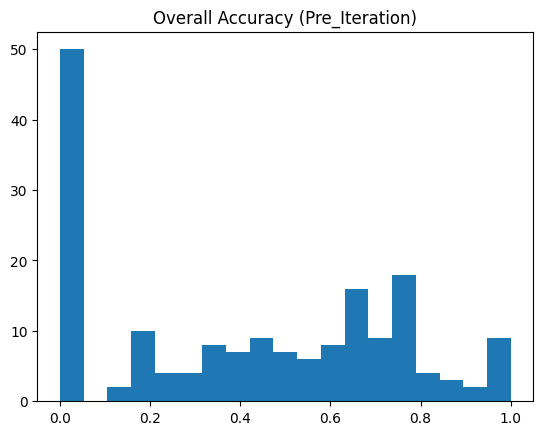

In [83]:
bins = np.linspace(0, 1, 20)
import matplotlib.pyplot as plt
plt.hist(f1s.values(), bins, label='Overall Accuracy')
plt.title("Overall Accuracy (Pre_Iteration)")


Text(0.5, 1.0, 'Positive Accuracy (Pre_Iteration)')

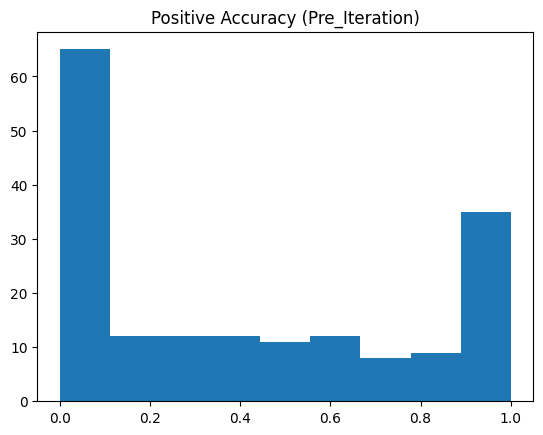

In [84]:
plt.hist(accuracies_positive.values(), bins, label='Positive Accuracy')
plt.title("Positive Accuracy (Pre_Iteration)")

In [63]:
scatter(np.arange(len(accuracies_positive)), list(accuracies_positive.values()), hover_name=labels, title="Accuracy of Positive Generation (Pre-Iteration)",range_y=[-0.1,1.1])

In [64]:
accuracies = []
accuracies_positive = {}
accuracies_negative = []
f1s = []
precisions = []
recalls = []
for head, (pred_pos, pred_neg, correct_pos, correct_neg) in v2.items():
    true_pos = 0
    true_neg = 0
    false_pos = 0
    false_neg = 0
    for eg in pred_pos:
        if eg in correct_pos:
            true_pos += 1
        else:
            false_pos += 1
    for eg in pred_neg:
        if eg in correct_neg:
            true_neg += 1
        else:
            false_neg += 1
    accuracy = (true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg)
    accuracy_positive = true_pos / (true_pos + false_pos)
    accuracy_negative = true_neg / (true_neg + false_neg)
    precision = true_pos / (true_pos + false_pos)
    try:
        recall = true_pos / (true_pos + false_neg)
        recalls.append(recall)
    except ZeroDivisionError:
        pass
    precisions.append(precision)

    # accuracies_positive.append(accuracy_positive)
    accuracies_positive[head] = accuracy_positive
    accuracies_negative.append(accuracy_negative)
    accuracies.append(accuracy)
    f1 = 2 * true_pos / (2 * true_pos + false_pos + false_neg)
    f1s.append(f1)



print(np.mean(accuracies))
print(np.mean(list(accuracies_positive.values())))
print(np.mean(accuracies_negative))
print(np.mean(f1s))
print(np.mean(precisions))
print(np.mean(recalls))

0.5954229797979799
0.4034090909090909
0.7856534090909091
0.40573377829807455
0.4034090909090909
0.6660497535647056


In [65]:
scatter(np.arange(len(accuracies)), accuracies, title="Overall Accuracy (Post_Iteration)",range_y=[-0.1,1.1])

In [66]:
scatter(np.arange(len(accuracies_positive)), list(accuracies_positive.values()), hover_name=labels, title="Accuracy of Positive Generation (Post-Iteration)", range_y=[-0.1,1.1]) # add hover